In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Load the dataset
data = pd.read_csv("https://raw.githubusercontent.com/abhivyakti003/Diabetes-Prediction/main/diabetes.csv")

data.info(), data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


(None,
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
 0            6      148             72             35        0  33.6   
 1            1       85             66             29        0  26.6   
 2            8      183             64              0        0  23.3   
 3            1       89             66             23       94  28.1   
 4            0      137             40             35      168  43.1   
 
    DiabetesPedigreeFunction  Age  Outcome  
 0                     0.627   50        1  
 1                     0.351   31        0  
 2                     0.672   32        1  
 3                     0.167   21        0  
 4                     2.288   33        1  )

In [ ]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
data.shape

(768, 9)

DATA PREPROCESSING

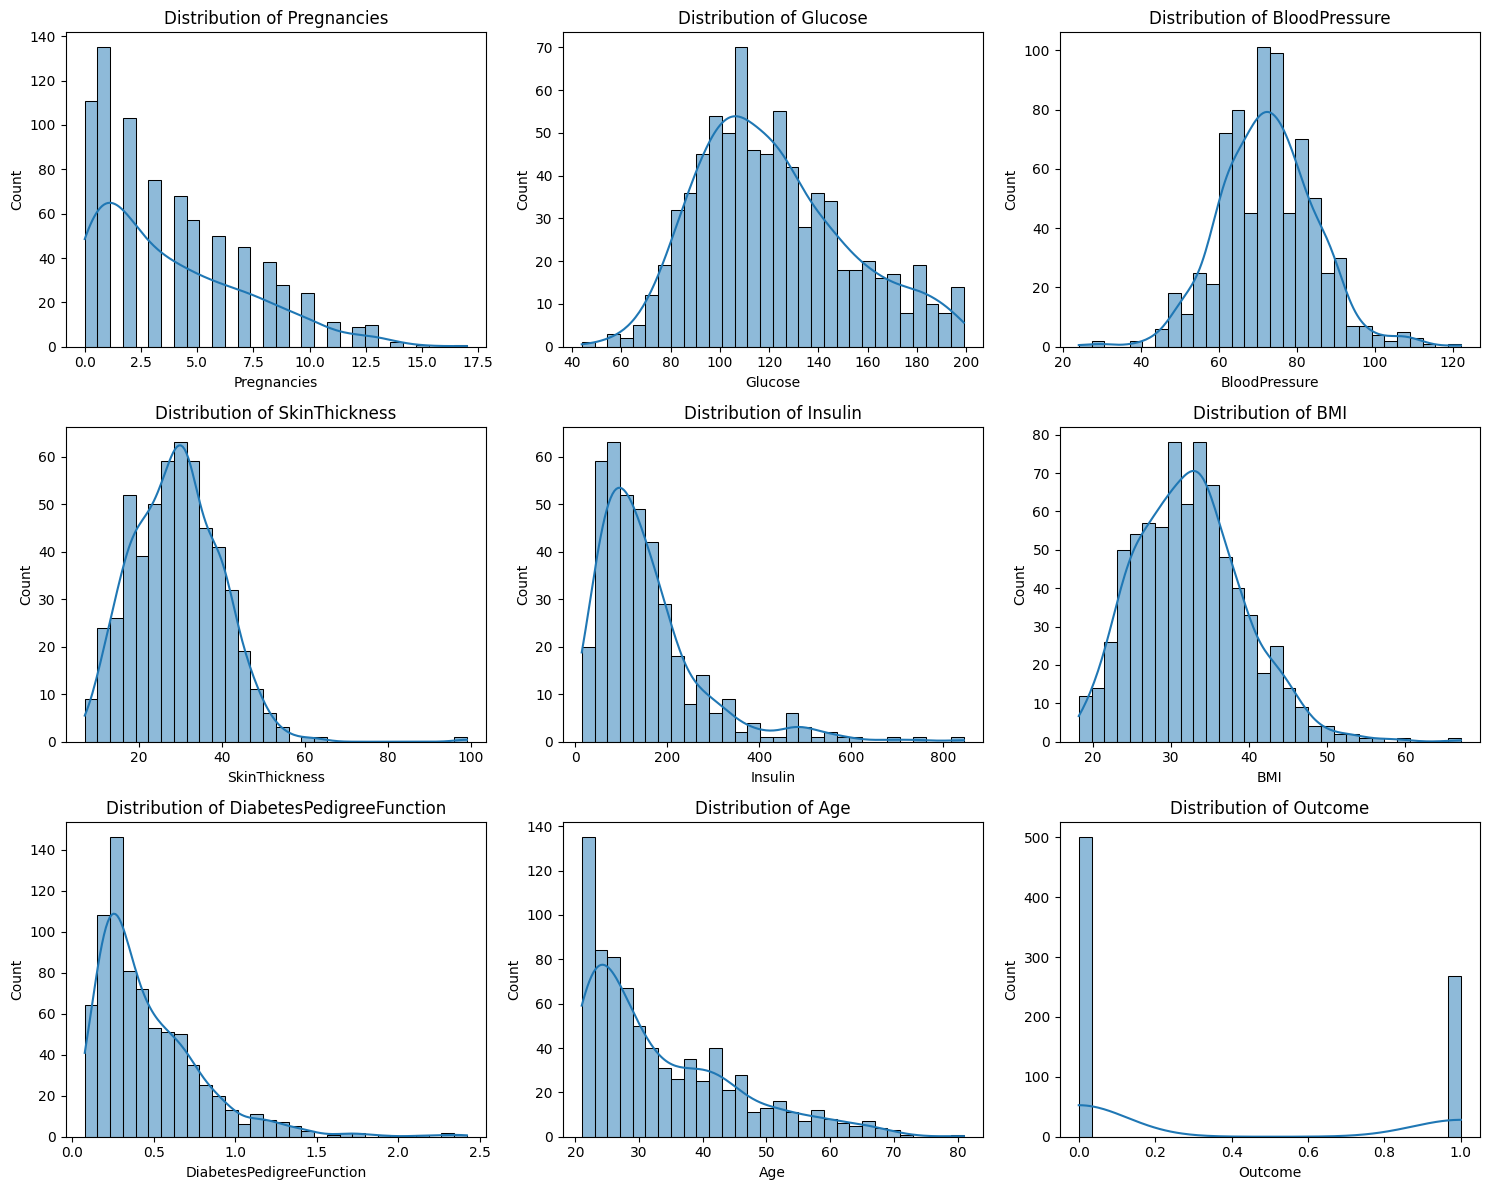

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Replace zero values in specific columns
columns_with_zero_values = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data[columns_with_zero_values] = data[columns_with_zero_values].replace(0, np.nan)

# Display the number of missing values per column after replacement
missing_values = data.isnull().sum()

# Summary statistics to identify outliers or unusual values
summary_statistics = data.describe()

# Plot distributions of features and handle missing values
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, column in enumerate(data.columns):
    sns.histplot(data[column], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f"Distribution of {column}")

plt.tight_layout()
plt.show()

print("\nMissing values present in the data are: \n", missing_values)
print("\nSummary statistics of the data are: \n", summary_statistics)
#missing_values, summary_statistics


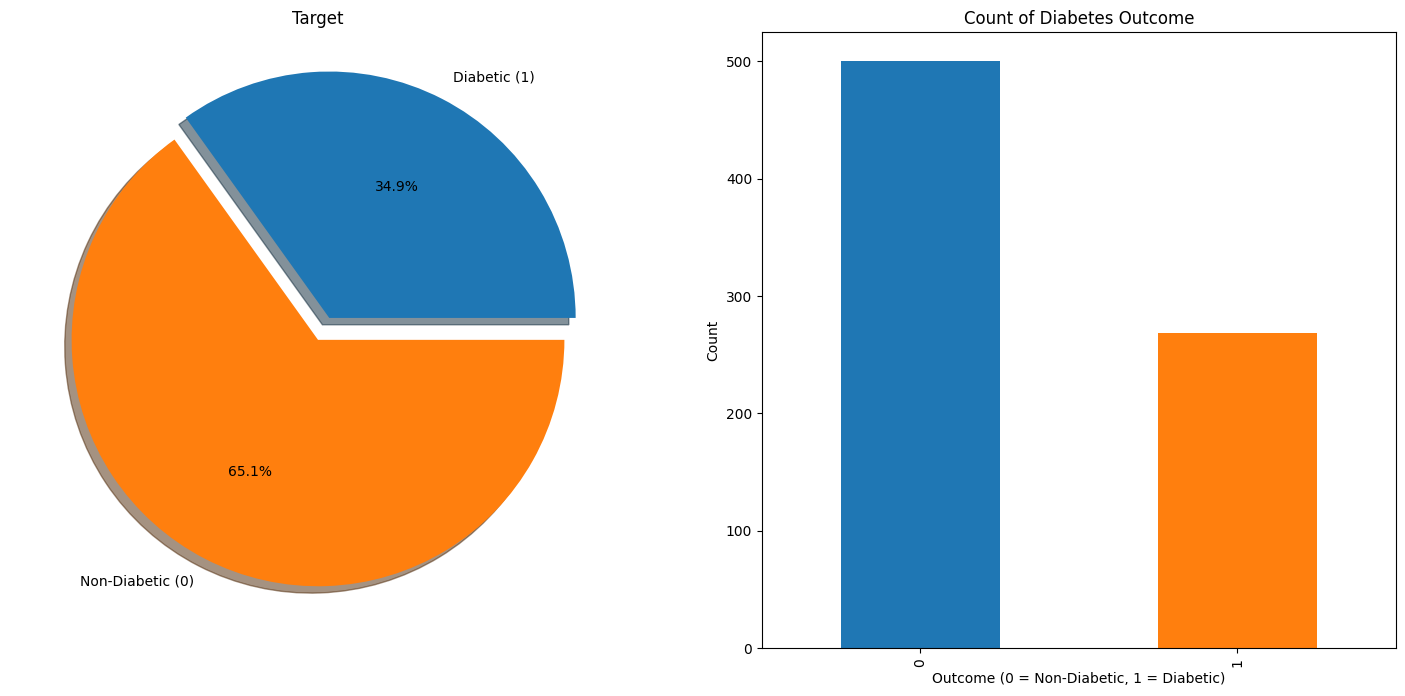

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Ensure the correct color assignment
data['Outcome'].value_counts().sort_index(ascending=False).plot.pie(
    explode=[0.1, 0],  # Explode the diabetic slice (assuming 1 is diabetic)
    autopct="%1.1f%%",
    ax=ax[0],
    shadow=True,
    labels=['Diabetic (1)', 'Non-Diabetic (0)'],  # Label slices
    colors=['#1f77b4', '#ff7f0e']  # Blue for Diabetic, Orange for Non-Diabetic
)
ax[0].set_title('Target')
ax[0].set_ylabel('')

# Bar plot for target variable
data['Outcome'].value_counts().plot(kind='bar', ax=ax[1], color=['#1f77b4', '#ff7f0e'])
ax[1].set_title('Count of Diabetes Outcome')
ax[1].set_xlabel('Outcome (0 = Non-Diabetic, 1 = Diabetic)')
ax[1].set_ylabel('Count')

# Show the plot
plt.show()


In [ ]:
data.shape

(768, 9)

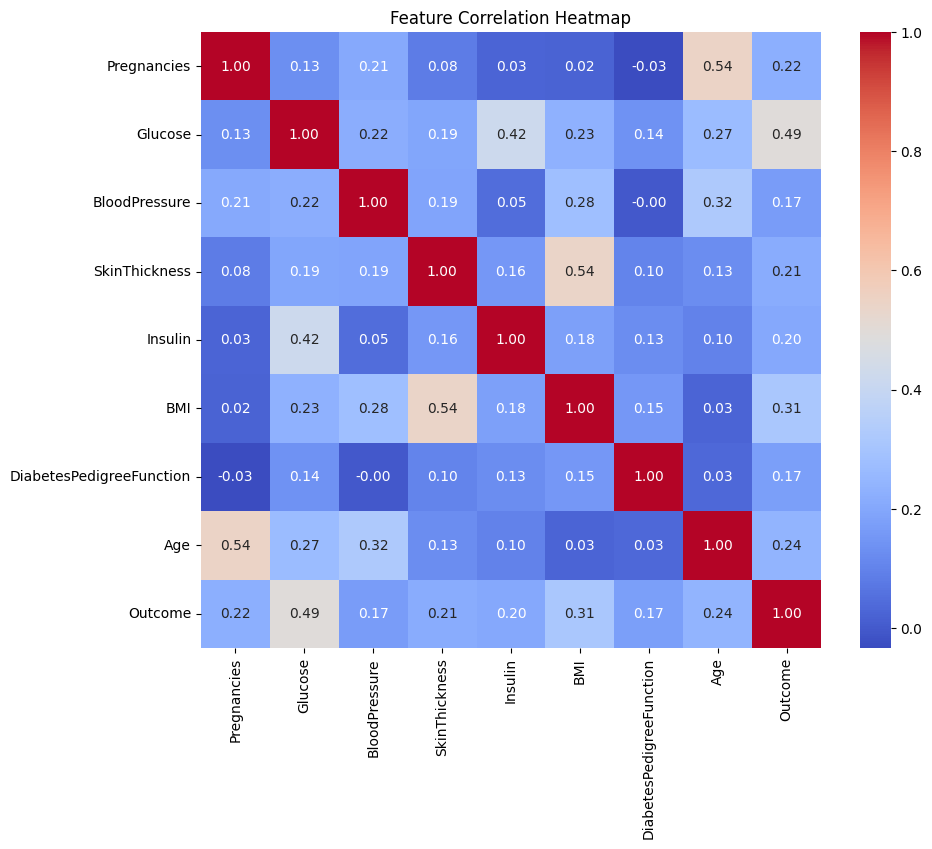

,Outcome
Outcome,1.000000
Glucose,0.492782
BMI,0.312038
Age,0.238356
Pregnancies,0.221898
SkinThickness,0.214873
Insulin,0.203790
DiabetesPedigreeFunction,0.173844
BloodPressure,0.165723


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# missing values using the median
imputer = SimpleImputer(strategy='median')
data[columns_with_zero_values] = imputer.fit_transform(data[columns_with_zero_values])

# Scale numerical features
scaler = StandardScaler()
scaled_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
data[scaled_columns] = scaler.fit_transform(data[scaled_columns])

# Compute correlations with the Outcome variable
correlations = data.corr()['Outcome'].sort_values(ascending=False)

# Plot a heatmap of the correlations
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

correlations

In [ ]:
data.shape

(768, 9)

In [ ]:
#calculate number of outliers
import numpy as np
from scipy.stats import zscore
# Load your diabetes dataset

# Display basic statistics
print(data.describe())

# Calculate Z-scores
z_scores = np.abs(zscore(data))

# Define a threshold for Z-score
threshold = 3

# Identify outliers
outliers = np.where(z_scores > threshold)
print(f"Number of outliers: {len(outliers[0])}")

# Remove outliers
df_cleaned = data[(z_scores < threshold).all(axis=1)]

# Check dataset size before and after
print(f"Original data size: {data.shape}")
print(f"Cleaned data size: {df_cleaned.shape}")


        Pregnancies       Glucose  BloodPressure  SkinThickness       Insulin  \
count  7.680000e+02  7.680000e+02   7.680000e+02   7.680000e+02  7.680000e+02   
mean  -6.476301e-17  4.625929e-18   5.782412e-18  -1.526557e-16  1.503427e-17   
std    1.000652e+00  1.000652e+00   1.000652e+00   1.000652e+00  1.000652e+00   
min   -1.141852e+00 -2.552931e+00  -4.002619e+00  -2.516429e+00 -1.467353e+00   
25%   -8.448851e-01 -7.201630e-01  -6.937615e-01  -4.675972e-01 -2.220849e-01   
50%   -2.509521e-01 -1.530732e-01  -3.198993e-02  -1.230129e-02 -1.815412e-01   
75%    6.399473e-01  6.112653e-01   6.297816e-01   3.291706e-01 -1.554775e-01   
max    3.906578e+00  2.542658e+00   4.104082e+00   7.955377e+00  8.170442e+00   

                BMI  DiabetesPedigreeFunction           Age     Outcome  
count  7.680000e+02              7.680000e+02  7.680000e+02  768.000000  
mean   2.613650e-16              2.451743e-16  1.931325e-16    0.348958  
std    1.000652e+00              1.000652e+00  1

In [ ]:
data.shape

(768, 9)

In [ ]:
for feature in data:
    Q1=data[feature].quantile(0.25)
    Q3=data[feature].quantile(0.75)
    IQR = Q3-Q1
    lower=Q1-1.5*IQR
    upper=Q3+1.5*IQR
    if data[(data[feature]>upper)].any(axis=None):
        print(feature, "yes")
    else:
        print(feature,"no")




Pregnancies yes
Glucose no
BloodPressure yes
SkinThickness yes
Insulin yes
BMI yes
DiabetesPedigreeFunction yes
Age yes
Outcome no


In [ ]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.866045,-0.031990,0.670643,-0.181541,0.166619,0.468492,1.425995,1
1,-0.844885,-1.205066,-0.528319,-0.012301,-0.181541,-0.852200,-0.365061,-0.190672,0
2,1.233880,2.016662,-0.693761,-0.012301,-0.181541,-1.332500,0.604397,-0.105584,1
3,-0.844885,-1.073567,-0.528319,-0.695245,-0.540642,-0.633881,-0.920763,-1.041549,0
4,-1.141852,0.504422,-2.679076,0.670643,0.316566,1.549303,5.484909,-0.020496,1


BMI_category
0    768
Name: count, dtype: int64


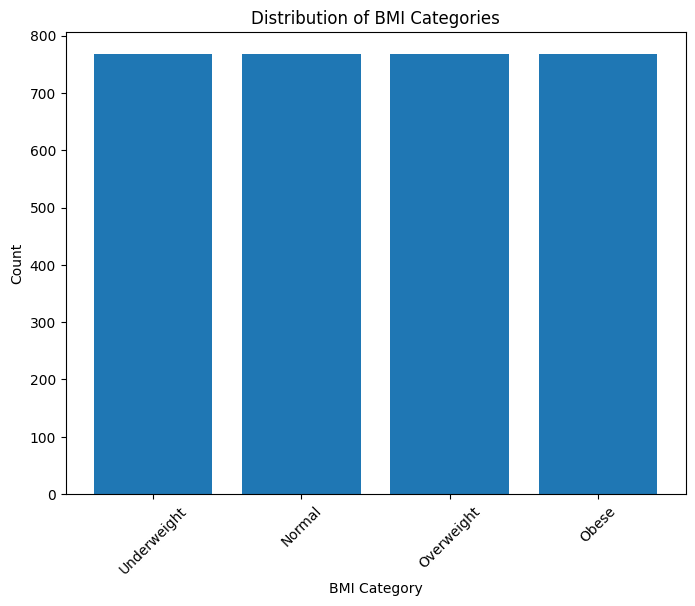

In [ ]:
# Feature Engineering
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 0  # Underweight
    elif 18.5 <= bmi < 24.9:
        return 1  # Normal
    elif 25 <= bmi < 29.9:
        return 2  # Overweight
    else:
        return 3  # Obese

x=data.copy()
# Apply categorization
x['BMI_category'] = data['BMI'].apply(categorize_bmi)
print(x['BMI_category'].value_counts())

# Display category distribution for insight
bmi_category_counts = x['BMI_category'].value_counts().sort_index()
category_labels = ['Underweight', 'Normal', 'Overweight', 'Obese']

# Plot distribution of BMI categories
plt.figure(figsize=(8, 6))
plt.bar(category_labels, bmi_category_counts)
plt.title('Distribution of BMI Categories')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()




Glucose_category
0    768
Name: count, dtype: int64


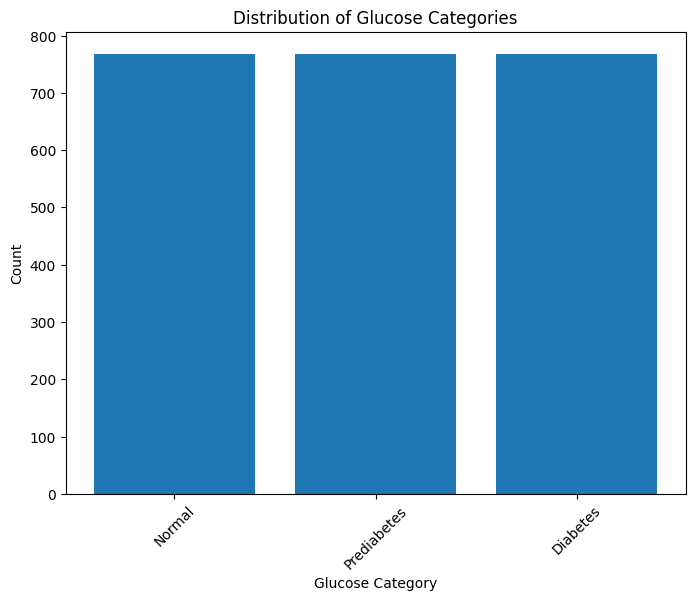

In [ ]:
# Feature Engineering
def categorize_glucose(glucose):
    if glucose < 100:

        return 0  # Normal

    elif 100 <= glucose < 126:

        return 1  # Prediabetes

    else:

        return 2  # Diabetes

x=data.copy()
# Apply categorization
x['Glucose_category'] = data['Glucose'].apply(categorize_bmi)
print(x['Glucose_category'].value_counts())

# Display category distribution for insight
bmi_category_counts = x['Glucose_category'].value_counts().sort_index()
category_labels = [ 'Normal', 'Prediabetes', 'Diabetes']

# Plot distribution of Glucose categories
plt.figure(figsize=(8, 6))
plt.bar(category_labels, bmi_category_counts)
plt.title('Distribution of Glucose Categories')
plt.xlabel('Glucose Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()




In [ ]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.866045,-0.031990,0.670643,-0.181541,0.166619,0.468492,1.425995,1
1,-0.844885,-1.205066,-0.528319,-0.012301,-0.181541,-0.852200,-0.365061,-0.190672,0
2,1.233880,2.016662,-0.693761,-0.012301,-0.181541,-1.332500,0.604397,-0.105584,1
3,-0.844885,-1.073567,-0.528319,-0.695245,-0.540642,-0.633881,-0.920763,-1.041549,0
4,-1.141852,0.504422,-2.679076,0.670643,0.316566,1.549303,5.484909,-0.020496,1


In [ ]:
data.shape

(768, 9)

DEFINING AND TRAINING THE MODEL


In [ ]:
# Define features and target
X = data.drop(columns=['Outcome'])
y = data['Outcome']

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "SVM": SVC(probability=True)
}

In [ ]:
# Evaluate models using cross-validation
import warnings
warnings.filterwarnings("ignore")
results = {}
for name, model in models.items():
    try:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
        results[name] = cv_scores.mean()
    except Exception as e:
        print(f"Error with model {name}: {e}")

Error with model XGBoost: 'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Info] Number of positive: 171, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348269 -> initscore=-0.626657
[LightGBM] [Info] Start training from score -0.626657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [ ]:
# Display results
print("Model Performance (Mean ROC-AUC):\n")
for name, score in results.items():
    print(f"{name}: {score:.4f}")

Model Performance (Mean ROC-AUC):

Logistic Regression: 0.8346
Random Forest: 0.8315
LightGBM: 0.8198
SVM: 0.8399


In [ ]:
# Train the best model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

SVC(probability=True)

In [ ]:
# Evaluate on test data
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"Best Model: {best_model_name}")
print(f"ROC-AUC on Test Data: {roc_auc:.4f}")

Best Model: SVM
ROC-AUC on Test Data: 0.8072


GRAPHS,FEATURE IMPORTANCE AND EVALUATION

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

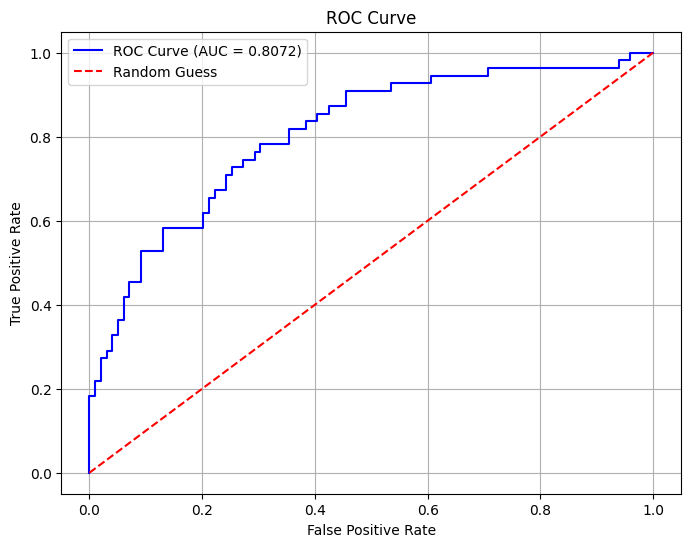

In [ ]:
# Plot ROC CURVE
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guess')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

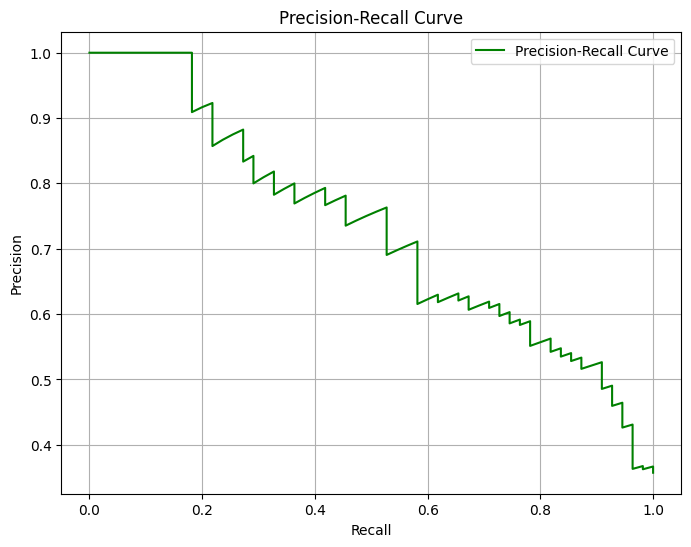

In [ ]:
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve", color='green')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

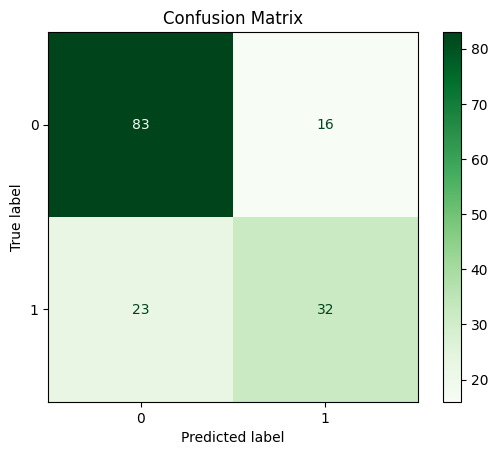

In [ ]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.show()

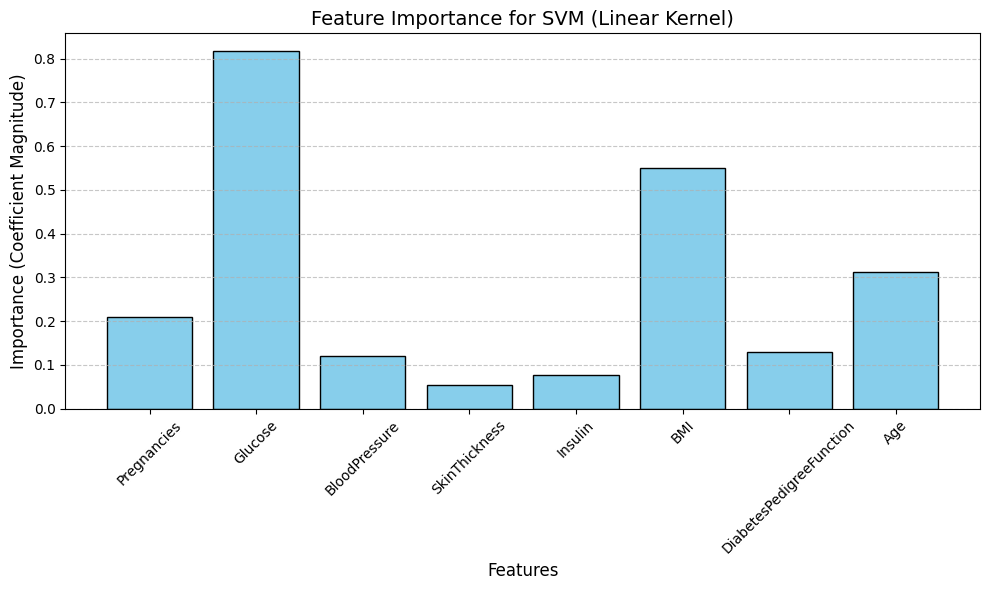

In [ ]:
# Extract feature importances
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

# Define features and target
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Split the data
X = data.drop(columns=['Outcome'])
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a linear SVM
best_model = SVC(probability=True, kernel='linear')  # Force linear kernel
best_model.fit(X_train, y_train)

if best_model.kernel == 'linear':
    feature_importances = np.abs(best_model.coef_).ravel()

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importances)), feature_importances, color='skyblue', edgecolor='black')
    plt.xticks(range(len(feature_importances)), features, rotation=45, fontsize=10)
    plt.title("Feature Importance for SVM (Linear Kernel)", fontsize=14)
    plt.ylabel("Importance (Coefficient Magnitude)", fontsize=12)
    plt.xlabel("Features", fontsize=12)
    plt.tight_layout()   # Adjusts plot for better spacing
    plt.grid(axis='y', linestyle='--', alpha=0.7)   # Adds horizontal gridlines for readability
    plt.show()
else:
    print("Feature importance visualization is only supported for linear kernels.")